# DESeq2 analysis with featureCounts meta counts matrix

using the counts matrix generated from featureCounts that counted number of methylated sequences for a meta feature

volcano plots are generated with ggplot in volcano_plots.ipynb file

In [1]:
# loading required packages
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano)
library(dplyr)
library(ggh4x)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’

## I. Load and clean data frames
this includes the featureCounts matrix of meta features and the meta data of the samples (which includes the phase treatment info)

**counts matrix generated from featureCounts (meta features)**

In [2]:
# loading counts matrix
counts <- read.table('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/sam_files/fc_counts.txt', header=TRUE)

# removing the length column
counts <- counts[,-2]

dim(counts) # 38,828 genes total
head(counts)

[1] 38828    31

,GeneID,X2018..BBB.WBO.B21.CV_alignment.sam,X2018..BPO.BPO.O16.CV_alignment.sam,X2018..WBR.BBY.W25.CV_alignment.sam,X2018..BBB.WBV.B70.CV_alignment.sam,X2018..BPR.BPG.O38.CV_alignment.sam,X2018..WBV.WBO.W23.CV_alignment.sam,X2018..BBO.BBO.B16.CV_alignment.sam,X2018..BPR.BPR.O02.CV_alignment.sam,X2018..WBV.WBR.W12.CV_alignment.sam,⋯,X2018..WPO.BPO.G16.CV_alignment.sam,X2018..BBR.BBG.B38.CV_alignment.sam,X2018..WBG.WBG.W44.CV_alignment.sam,X2018..WPO.BPY.G28.CV_alignment.sam,X2018..BBR.BBY.B26.CV_alignment.sam,X2018..WBO.BBR.W03.CV_alignment.sam,X2018..WPR.BPY.G25.CV_alignment.sam,X2018..BBY.WBG.B42.CV_alignment.sam,X2018..WBO.WBV.W64.CV_alignment.sam,X2018..WPV.BPR.G11.CV_alignment.sam
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111112434,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111120752,2,1,0,2,0,0,0,2,0,⋯,0,0,0,1,1,0,1,0,1,0
6,LOC111128944,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [3]:
# removing the extra info from the file name
cleaned_column_names <- gsub("^X2018\\.\\.", "", gsub("\\.CV_alignment\\.sam$", "", colnames(counts)))
head(cleaned_column_names)

# replace the '.' with '-'
cleaned_column_names2 <- gsub('\\.', "-", cleaned_column_names)
head(cleaned_column_names2)

# now assigning to the columns
colnames(counts) = cleaned_column_names2
head(counts)

[1] "GeneID"      "BBB.WBO.B21" "BPO.BPO.O16" "WBR.BBY.W25" "BBB.WBV.B70"
[6] "BPR.BPG.O38"

[1] "GeneID"      "BBB-WBO-B21" "BPO-BPO-O16" "WBR-BBY-W25" "BBB-WBV-B70"
[6] "BPR-BPG-O38"

,GeneID,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
2,LOC111126949,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,LOC111112434,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,0
5,LOC111120752,2,1,0,2,0,0,0,2,0,⋯,0,0,0,1,1,0,1,0,1,0
6,LOC111128944,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [4]:
# setting the gene name as the row name and deleting that column
rownames(counts) <- counts$GeneID
counts2 <- counts[-1]

head(counts2)

,BBB-WBO-B21,BPO-BPO-O16,WBR-BBY-W25,BBB-WBV-B70,BPR-BPG-O38,WBV-WBO-W23,BBO-BBO-B16,BPR-BPR-O02,WBV-WBR-W12,BBO-BBY-B27,⋯,WPO-BPO-G16,BBR-BBG-B38,WBG-WBG-W44,WPO-BPY-G28,BBR-BBY-B26,WBO-BBR-W03,WPR-BPY-G25,BBY-WBG-B42,WBO-WBV-W64,WPV-BPR-G11
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
LOC111126949,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111110729,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111112434,0,0,0,0,0,0,0,2,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111120752,2,1,0,2,0,0,0,2,0,0,⋯,0,0,0,1,1,0,1,0,1,0
LOC111128944,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [5]:
# removing rows that have really low counts
counts2 <- counts2[-which(rowSums(counts2[sapply(counts2, is.numeric)]) < 10),]
dim(counts2)

[1] 13544    30

**sample meta data table** which includes info about treatments

In [40]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/CV_CE18_meta.csv')

# changing rownames to the unique sample ID
rownames(meta) <- meta$unique_ID

meta$treatment <- paste(meta$Phase1, meta$Phase2)

# pulling out only the rows I need
meta <- select(meta, Phase1, Phase2, treatment)
head(meta)

,Phase1,Phase2,treatment
,<chr>,<chr>,<chr>
BBB-WBO-B21,hypoxic,control,hypoxic control
BBB-WBV-B70,hypoxic,control,hypoxic control
BBO-BBO-B16,hypoxic,hypoxic,hypoxic hypoxic
BBO-BBY-B27,hypoxic,hypoxic,hypoxic hypoxic
BBO-WBO-B16,hypoxic,control,hypoxic control
BBO-WBV-B64,hypoxic,control,hypoxic control


for analysis - sample names need to be in the same order for the counts matrix and meta data

In [41]:
# checking if samples are in the right order
all(rownames(meta) == colnames(counts2)) # FALSE - not in the same order

[1] TRUE

In [42]:
# setting the same order for counts matrix and meta data
counts2 <- counts2[,rownames(meta)]
all(rownames(meta) == colnames(counts2))

[1] TRUE

In [43]:
# checking dimensions
dim(meta) # 30 rows
dim(counts2) # 30 columns

[1] 30  3

[1] 13544    30

In [10]:
write.csv(counts2, "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/counts_formatted.csv")

**to use for analysis:**
- counts2 - counts matrix of meta features for 30 samples
- meta - meta data frame for sample information 
both are formatted as needed for analysis and will be used going forward

## II. DESeq Analysis
Using DESeq2 to compare between two treatments the differences in methylation.

All DESeq analysis is using the same arguments:
- type = "normal"
- lfcThreshold = 0.25
- cooksCutoff = FALSE
- independentFiltering = FALSE
- pCutOff = 0.05

Starting with:
### **Effects of Phase 1, regardless of phase 2**

In [48]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1_dds <- DESeqDataSetFromMatrix(countData = counts2,
                              colData = meta, 
                              design = ~ Phase1)
p1_dds=DESeq(p1_dds)
resultsNames(p1_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 607 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"              "Phase1_control_vs_both" "Phase1_hypoxic_vs_both"
[4] "Phase1_warm_vs_both"

starting first with looking at **Phase 1 warm vs. control**

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13538 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 439, 3.2%
LFC < -0.25 (down) : 4, 0.03%
outliers [1]       : 601, 4.4%
low counts [2]     : 6744, 50%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



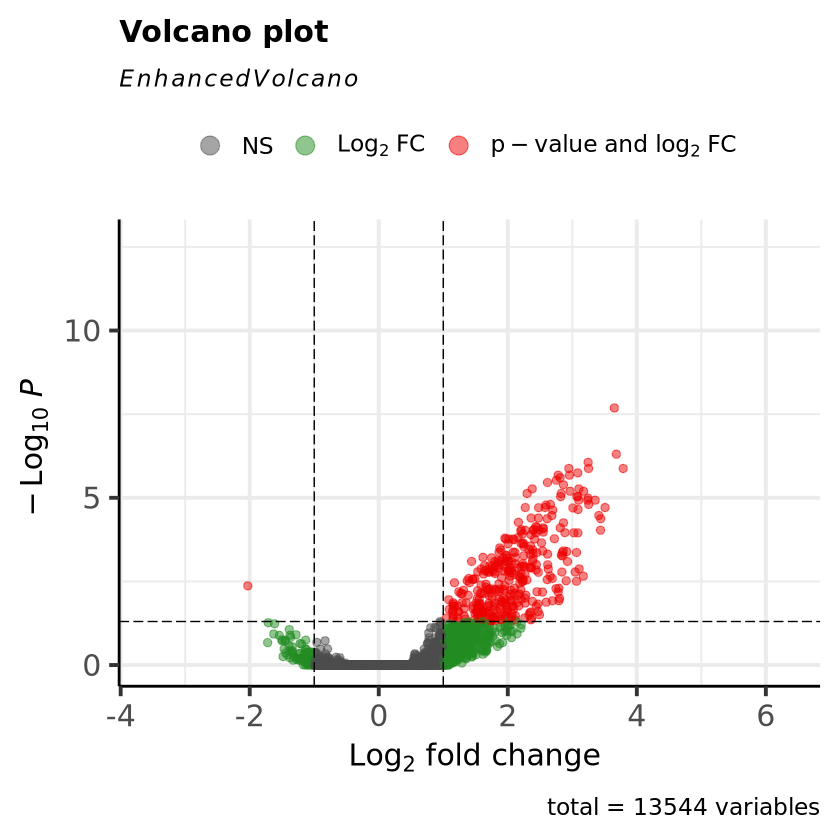

In [13]:
contrast1 <- c("Phase1", "warm", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p1wc<-lfcShrink(p1_dds, # dds object
                      contrast = contrast1, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p1wc)

EnhancedVolcano(ls_p1wc, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

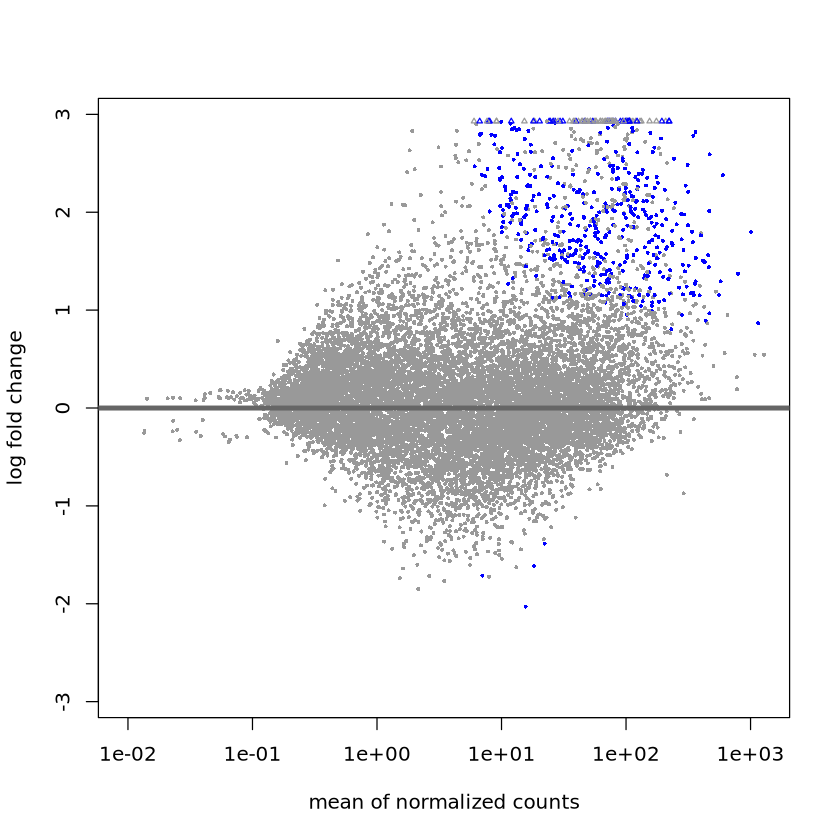

In [14]:
plotMA(ls_p1wc)

In [15]:
# saving data into a csv file to look at kegg enrichment
write.csv(ls_p1wc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/p1wc_lfc25_genes.csv')

In [16]:
# creating df of DESeq result
p1wc_shrink <- as.data.frame(ls_p1wc)

# adding column to denote that these are for warm vs. control samples
p1wc_shrink$plot <- 'warm_vs_control'

# adding column to tell us if this gene has more methylation in warming or control
p1wc_shrink$more_me_in <- ifelse(p1wc_shrink$log2FoldChange<0 & p1wc_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p1wc_shrink$log2FoldChange>0 & p1wc_shrink$padj < 0.05, "warm", # pos ES = pathway for warm
                               "not significant"))

head(p1wc_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,plot,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC111120752,0.9171026,0.5117345,0.7219483,0.3625391,0.71694919,NA,warm_vs_control,NA
LOC111109452,1.3692365,1.0072548,0.7205748,1.0509038,0.29330277,NA,warm_vs_control,NA
LOC111124802,160.7331187,0.4591660,0.1879969,1.1126035,0.26587874,1.0000000,warm_vs_control,not significant
LOC111101273,55.0404755,0.4055670,0.2258263,0.6888791,0.49089935,1.0000000,warm_vs_control,not significant
LOC111101250,77.7947775,-0.6027753,0.2031945,-1.7361458,0.08253806,0.6036878,warm_vs_control,not significant
LOC111101262,188.9039051,0.1674635,0.1795188,0.0000000,1.00000000,1.0000000,warm_vs_control,not significant


repeating above, but looking at **Phase 1 hypoxic vs. control**

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13538 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 0, 0%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 601, 4.4%
low counts [2]     : 6, 0.044%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



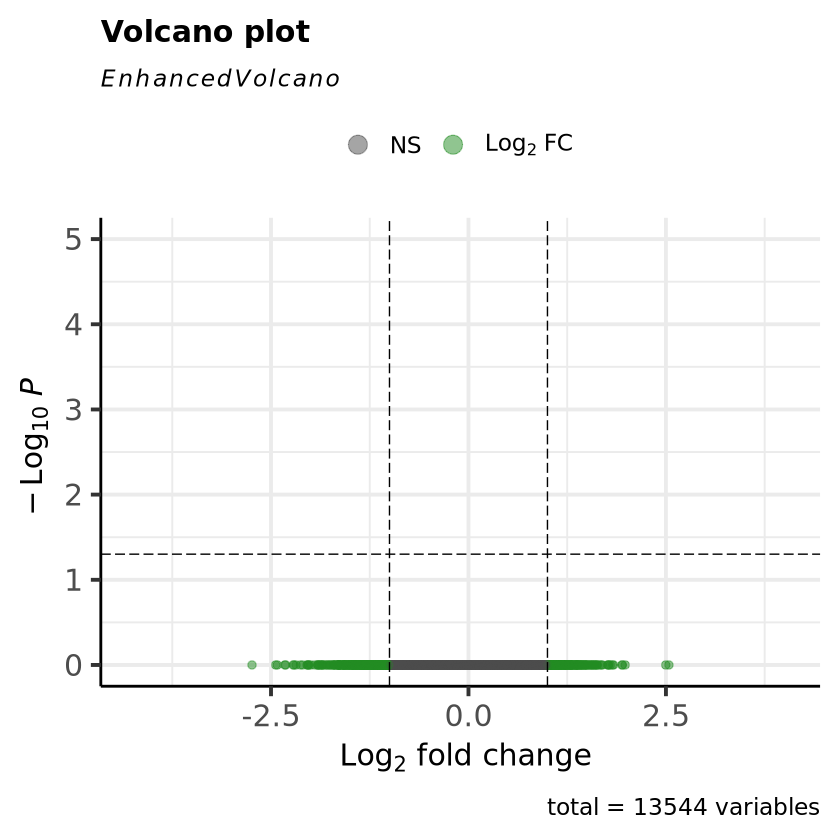

In [17]:
contrast2 <- c("Phase1", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p1hc<-lfcShrink(p1_dds, # dds object
                      contrast = contrast2, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p1hc)

EnhancedVolcano(ls_p1hc, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [18]:
# creating df of DESeq result
p1hc_shrink <- as.data.frame(ls_p1hc)

# adding column to denote that these are for hypoxic vs. control samples
p1hc_shrink$plot <- 'hypoxic_vs_control'

# adding column to tell us if this gene has more methylation in hypoxia or control
p1hc_shrink$more_me_in <- ifelse(p1hc_shrink$log2FoldChange<0 & p1hc_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p1hc_shrink$log2FoldChange>0 & p1hc_shrink$padj < 0.05, "hypoxia", # pos ES = pathway for warm
                               "not significant"))

head(p1hc_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,plot,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC111120752,0.9171026,-0.47211850,0.7009473,-0.3168833,0.7513321,1,hypoxic_vs_control,not significant
LOC111109452,1.3692365,0.45155837,0.7241066,0.2783545,0.7807402,1,hypoxic_vs_control,not significant
LOC111124802,160.7331187,0.01015871,0.1456254,0.0000000,1.0000000,1,hypoxic_vs_control,not significant
LOC111101273,55.0404755,-0.12778328,0.1709562,0.0000000,1.0000000,1,hypoxic_vs_control,not significant
LOC111101250,77.7947775,-0.20645216,0.1441565,0.0000000,1.0000000,1,hypoxic_vs_control,not significant
LOC111101262,188.9039051,0.01284188,0.1377824,0.0000000,1.0000000,1,hypoxic_vs_control,not significant


In [19]:
write.csv(p1hc_shrink, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/p1hc_lfc25_genes.csv')

now adding the two data frames together

In [20]:
phase1 <- rbind(p1wc_shrink, p1hc_shrink)
phase1<- na.omit(phase1)
tail(phase1)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,plot,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC1111169411,9.4281985,1.2951418,0.6177018,1.6919845,0.09064893,1,hypoxic_vs_control,not significant
LOC1111175661,2.0103277,0.4575072,0.4862327,0.4267652,0.66955039,1,hypoxic_vs_control,not significant
LOC1111176891,20.3169059,-0.2189097,0.2553920,0.0000000,1.00000000,1,hypoxic_vs_control,not significant
LOC1111171201,0.9885273,-0.4105955,0.6906943,-0.2325131,0.81613949,1,hypoxic_vs_control,not significant
LOC1111171151,0.3123175,-0.5419666,0.7202081,-0.4053920,0.68518943,1,hypoxic_vs_control,not significant
LOC1111166031,0.9944027,-0.1856000,0.6687666,0.0000000,1.00000000,1,hypoxic_vs_control,not significant


In [21]:
write.csv(phase1, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/volcano_data/phase1_lasting_genes.csv')

writing df of both analysis (phase 1 warm vs. control and phase 1 hypoxia vs. control) to a df - creating volcano plots in volcano_plots.ipynb file

now doing the same thing for CE of hypoxia

### **Effects of Phase 2, Given Phase 1**
in other words - looking at:
- phase 1 = control, phase 2 = hypoxia or control
- phase 2 = hypoxia, phase 2 = hypoxia or control

starting with **phase 1 = *control*** first

In [22]:
# first need to filter for samples that were control for phase 1
p1_control <- filter(meta, meta$Phase1 == 'control')
head(p1_control)

# now select those same samples out of the counts matrix
p1c_counts <- counts2[,colnames(counts2) %in% rownames(p1_control)]
head(p1c_counts)

,Phase1,Phase2
,<chr>,<chr>
WBB-WBV-W69,control,control
WBG-BBB-W56,control,hypoxic
WBG-WBG-W44,control,control
WBO-BBR-W03,control,hypoxic
WBO-WBV-W64,control,control
WBR-BBY-W25,control,hypoxic


,WBB-WBV-W69,WBG-BBB-W56,WBG-WBG-W44,WBO-BBR-W03,WBO-WBV-W64,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,3,1,0,0,1,0,0,0,0,1
LOC111109452,0,1,0,0,7,0,1,0,1,2
LOC111124802,418,455,76,20,305,122,120,57,289,202
LOC111101273,132,127,49,8,143,43,45,18,87,81
LOC111101250,212,261,56,7,201,91,96,24,254,109
LOC111101262,453,485,102,40,422,184,146,52,387,251


both have 6 samples, so they match and we're good to move on to the DESeq analysis

In [23]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1c_dds <- DESeqDataSetFromMatrix(countData = p1c_counts,
                              colData = p1_control, 
                              design = ~ Phase2)
p1c_dds=DESeq(p1c_dds)
resultsNames(p1c_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"                 "Phase2_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13274 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 1, 0.0075%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 175, 1.3%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



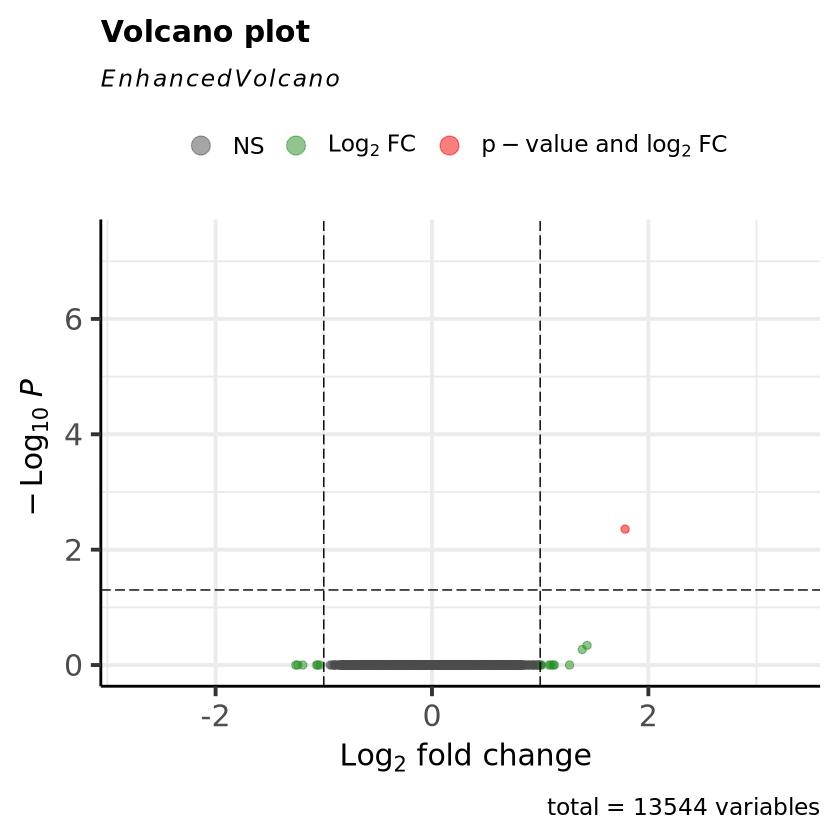

In [24]:
contrast2 <- c("Phase2", "hypoxic", "control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls_p1c<-lfcShrink(p1c_dds, # dds object
                      contrast = contrast2, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p1c)

EnhancedVolcano(ls_p1c, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [25]:
# creating df of DESeq result
p1c_shrink <- as.data.frame(ls_p1c)

# adding column to denote that these are for warm vs. control samples
p1c_shrink$phase1 <- 'control'

# adding column to tell us if this gene has more methylation in warming or control
p1c_shrink$more_me_in <- ifelse(p1c_shrink$log2FoldChange<0 & p1c_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p1c_shrink$log2FoldChange>0 & p1c_shrink$padj < 0.05, "hypoxic", # pos ES = pathway for warm
                               "not significant"))

head(p1c_shrink)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,phase1,more_me_in
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LOC111120752,0.2502286,-0.01831450,0.1324564,0.00000000,1.0000000,1,control,not significant
LOC111109452,0.6276346,-0.06431818,0.1758236,0.00000000,1.0000000,1,control,not significant
LOC111124802,143.4993752,0.01425287,0.1425472,0.00000000,1.0000000,1,control,not significant
LOC111101273,54.3974633,-0.25915086,0.1971998,-0.04640401,0.9629882,1,control,not significant
LOC111101250,88.6108831,0.06661223,0.1889832,0.00000000,1.0000000,1,control,not significant
LOC111101262,182.2669054,0.15981376,0.1181916,0.00000000,1.0000000,1,control,not significant


In [26]:
write.csv(p1c_shrink, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/p1control_p2hc_genes.csv')

now doing the same thing but for **phase 1 = *hypoxic***

In [27]:
# first need to filter for samples that were control for phase 1
p1_hypoxia <- filter(meta, meta$Phase1 == 'hypoxic')
head(p1_hypoxia)

# now select those same samples out of the counts matrix
p1h_counts <- counts2[,colnames(counts2) %in% rownames(p1_hypoxia)]
head(p1h_counts)

,Phase1,Phase2
,<chr>,<chr>
BBB-WBO-B21,hypoxic,control
BBB-WBV-B70,hypoxic,control
BBO-BBO-B16,hypoxic,hypoxic
BBO-BBY-B27,hypoxic,hypoxic
BBO-WBO-B16,hypoxic,control
BBO-WBV-B64,hypoxic,control


,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111120752,2,2,0,0,2,0,0,0,1,0
LOC111109452,0,0,0,0,1,1,10,12,0,2
LOC111124802,597,453,408,244,502,434,187,336,311,110
LOC111101273,173,146,115,75,171,158,64,115,137,45
LOC111101250,253,255,257,118,327,269,115,141,184,49
LOC111101262,645,634,502,364,647,677,246,389,355,108


both have 6 samples, so they match and we're good to move on to the DESeq analysis

In [28]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1h_dds <- DESeqDataSetFromMatrix(countData = p1h_counts,
                              colData = p1_hypoxia, 
                              design = ~ Phase2)
p1h_dds=DESeq(p1h_dds)
resultsNames(p1h_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



[1] "Intercept"                 "Phase2_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 13397 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 258, 1.9%
LFC < -0.25 (down) : 87, 0.65%
outliers [1]       : 302, 2.3%
low counts [2]     : 3570, 27%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



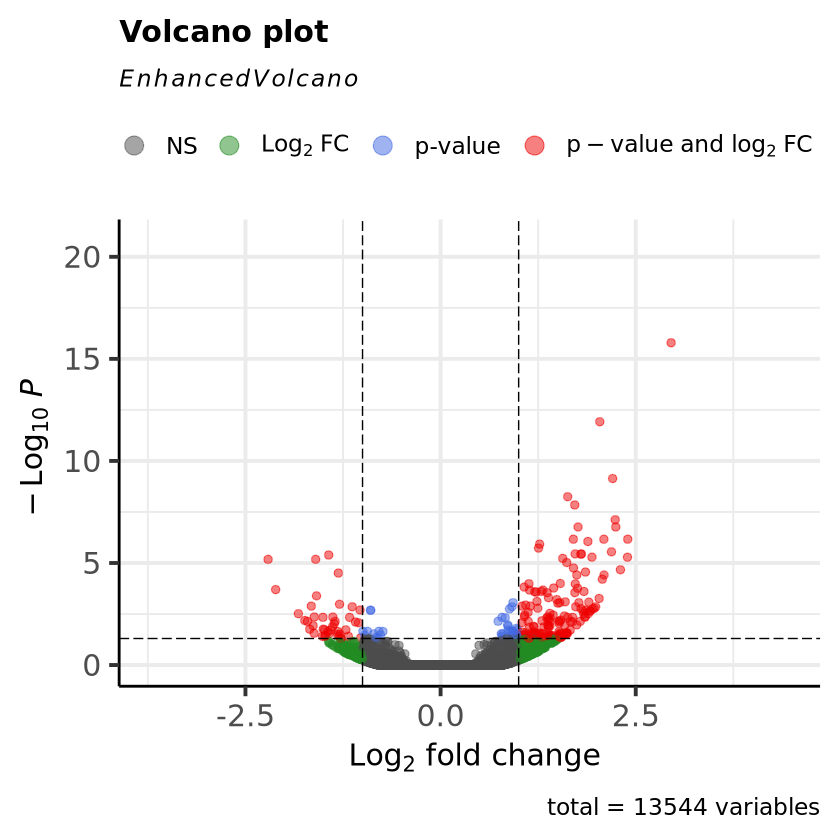

In [29]:
contrast3 <- c("Phase2", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.25 and normal shrinkage estimator
ls_p1h<-lfcShrink(p1h_dds, # dds object
                      contrast = contrast3, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p1h)

EnhancedVolcano(ls_p1h, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

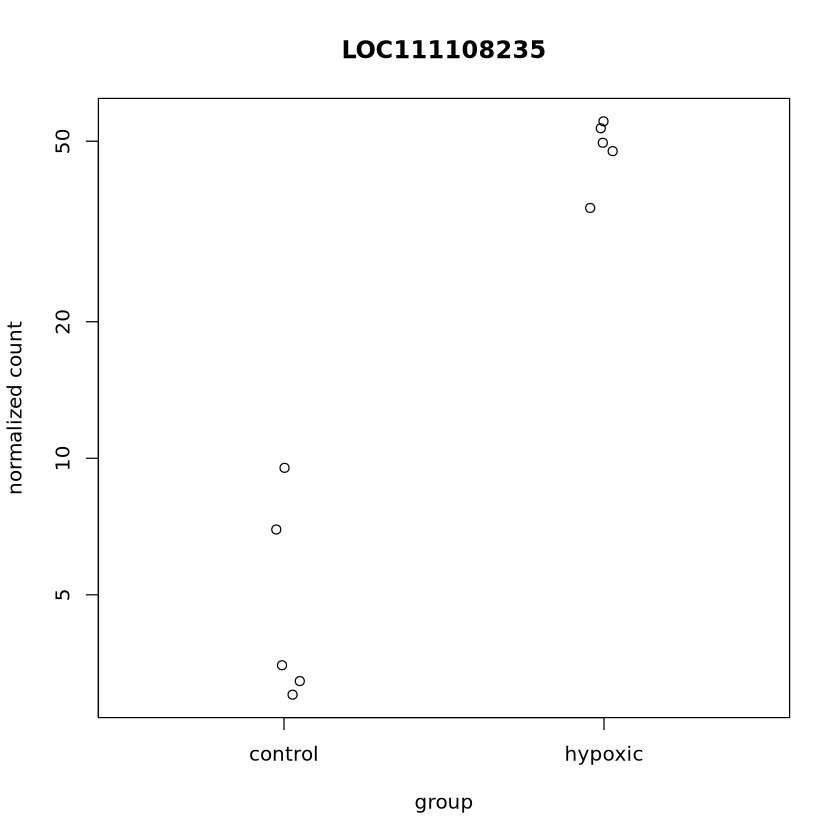

In [30]:
plotCounts(p1h_dds, gene=which.min(ls_p1h$padj), intgroup="Phase2")

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42
BBB-WBO-B21,0.00000,33.45774,37.58371,37.33702,32.22849,32.03489,36.72380,35.50753,36.24104,33.01657
BBB-WBV-B70,33.45774,0.00000,34.02500,35.93776,32.27563,33.00002,32.79953,34.95494,34.54939,38.58113
BBO-BBO-B16,37.58371,34.02500,0.00000,32.24923,33.51937,36.88948,29.39671,31.16789,29.39043,38.47542
BBO-BBY-B27,37.33702,35.93776,32.24923,0.00000,35.24649,35.26954,31.76518,32.34154,28.79042,40.09532
BBO-WBO-B16,32.22849,32.27563,33.51937,35.24649,0.00000,32.24318,33.59614,34.88267,33.47269,35.71032
BBO-WBV-B64,32.03489,33.00002,36.88948,35.26954,32.24318,0.00000,36.08347,36.56903,34.08124,37.26816


,X1,X2,Phase1,Phase2,sizeFactor
,<dbl>,<dbl>,<chr>,<fct>,<dbl>
BBB-WBO-B21,15.959357,0.2247667,hypoxic,control,1.5926578
BBB-WBV-B70,3.926827,12.1168840,hypoxic,control,1.3920522
BBO-BBO-B16,-11.410898,-2.2174511,hypoxic,hypoxic,1.1343082
BBO-BBY-B27,-11.548760,2.7233267,hypoxic,hypoxic,0.7651855
BBO-WBO-B16,6.737760,5.5290305,hypoxic,control,1.6685621
BBO-WBV-B64,9.867968,12.2960588,hypoxic,control,1.4671714


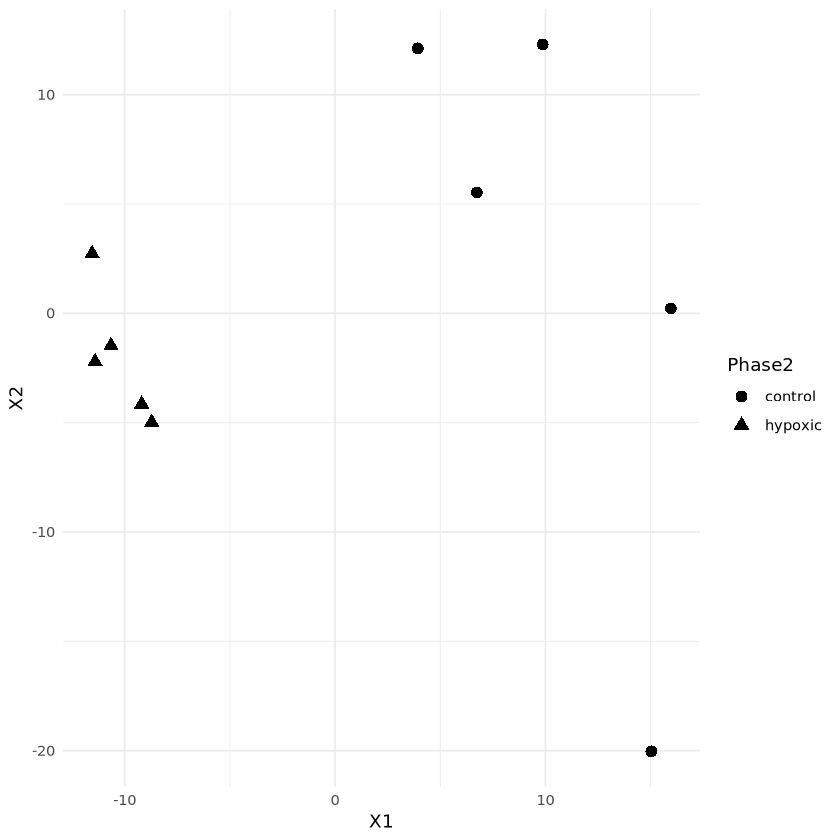

In [37]:
# MDS plot

# normalization & transformation
vsd <- vst(p1h_dds)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

# plot
ggplot(mds, aes(X1, X2, shape = Phase2)) + 
  geom_point(size = 3) +
  theme_minimal()

In [31]:
vsd <- vst(p1h_dds)
class(vsd)
head(colData(vsd),3)

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] "DESeqTransform"
attr(,"package")
[1] "DESeq2"

DataFrame with 3 rows and 3 columns
                 Phase1   Phase2 sizeFactor
            <character> <factor>  <numeric>
BBB-WBO-B21     hypoxic  control    1.59266
BBB-WBV-B70     hypoxic  control    1.39205
BBO-BBO-B16     hypoxic  hypoxic    1.13431

In [ ]:
mat <- assay(vsd)[ head(order(res$padj),30), ]

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'res' not found


In [ ]:
mat <- mat - rowMeans(mat)

ERROR: Error in eval(expr, envir, enclos): object 'mat' not found


In [ ]:
pheatmap(mat)

ERROR: Error in pheatmap(mat): could not find function "pheatmap"


In [ ]:
write.csv(ls_p1h, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/p1hyp_p2hc_genes.csv')


In [ ]:
# creating df of DESeq result
p1h_shrink <- as.data.frame(ls_p1h)

# adding column to denote that these are for warm vs. control samples
p1h_shrink$phase1 <- 'hypoxic'

# adding column to tell us if this gene has more methylation in warming or control
p1h_shrink$more_me_in <- ifelse(p1h_shrink$log2FoldChange<0 & p1h_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p1h_shrink$log2FoldChange>0 & p1h_shrink$padj < 0.05, "hypoxic", # pos ES = pathway for warm
                               "not significant"))

head(p1h_shrink)

now combining the two dataframes into one

In [ ]:
ce_df <- rbind(p1c_shrink, p1h_shrink)
ce_df <- na.omit(ce_df)
head(ce_df)
tail(ce_df)

writing csv file of combination of DESeq for all phase 1 control and comparing phase 2 control/hypoxia  & for all phase 1 hypoxia and comparing phase 2 control/hypoxia

aka faceting by first exposure

In [ ]:
write.csv(ce_df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/volcano_data/phase1_ch_ce_genes.csv')

### Effects of phase one, given phase 2
looking at samples that are:
- phase 1 = hypoxic or control, phase 2 = hypoxic
- phase 1 = hypoxic or control, phase 2 = control

starting with **phase 2 = control**

In [ ]:
# first need to filter for samples that were control for phase 1
p2_control <- filter(meta, meta$Phase2 == 'control')
head(p2_control)

# now select those same samples out of the counts matrix
p2c_counts <- counts2[,colnames(counts2) %in% rownames(p2_control)]
head(p2c_counts)

both have 6 samples, so they match and we're good to move on to the DESeq analysis

In [ ]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2c_dds <- DESeqDataSetFromMatrix(countData = p2c_counts,
                              colData = p2_control, 
                              design = ~ Phase1)
p2c_dds=DESeq(p2c_dds)
resultsNames(p2c_dds)

In [ ]:
contrast2 <- c("Phase1", "hypoxic", "control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls_p2c<-lfcShrink(p2c_dds, # dds object
                      contrast = contrast2, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p2c)

EnhancedVolcano(ls_p2c, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [ ]:
write.csv(ls_p2c, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/p1ch_p2c_genes.csv')

In [ ]:
# creating df of DESeq result
p2c_shrink <- as.data.frame(ls_p2c)

# adding column to denote that these are for warm vs. control samples
p2c_shrink$phase2 <- 'control'

# adding column to tell us if this gene has more methylation in warming or control
p2c_shrink$more_me_in <- ifelse(p2c_shrink$log2FoldChange<0 & p2c_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p2c_shrink$log2FoldChange>0 & p2c_shrink$padj < 0.05, "hypoxic", # pos ES = pathway for warm
                               "not significant"))

head(p2c_shrink)

now doing the same thing but for **phase 2 = *hypoxic***

In [ ]:
# first need to filter for samples that were control for phase 1
p2_hypoxia <- filter(meta, meta$Phase2 == 'hypoxic')
head(p2_hypoxia)

# now select those same samples out of the counts matrix
p2h_counts <- counts2[,colnames(counts2) %in% rownames(p2_hypoxia)]
head(p2h_counts)

both have 6 samples, so they match and we're good to move on to the DESeq analysis

In [ ]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2h_dds <- DESeqDataSetFromMatrix(countData = p2h_counts,
                              colData = p2_hypoxia, 
                              design = ~ Phase1)
p2h_dds=DESeq(p2h_dds)
resultsNames(p2h_dds)

In [ ]:
contrast3 <- c("Phase1", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.25 and normal shrinkage estimator
ls_p2h<-lfcShrink(p2h_dds, # dds object
                      contrast = contrast3, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p2h)

EnhancedVolcano(ls_p2h, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [ ]:
# creating df of DESeq result
p2h_shrink <- as.data.frame(ls_p2h)

# adding column to denote that these are for warm vs. control samples
p2h_shrink$phase2 <- 'hypoxic'

# adding column to tell us if this gene has more methylation in warming or control
p2h_shrink$more_me_in <- ifelse(p2h_shrink$log2FoldChange<0 & p2h_shrink$padj < 0.05, "control", #neg ES = pathway for control
                        ifelse(p2h_shrink$log2FoldChange>0 & p2h_shrink$padj < 0.05, "hypoxic", # pos ES = pathway for warm
                               "not significant"))

head(p2h_shrink)

now combining the two dataframes into one

In [ ]:
p2_ce_df <- rbind(p2c_shrink, p2h_shrink)
p2_ce_df <- na.omit(p2_ce_df)
head(p2_ce_df)
tail(p2_ce_df)

In [ ]:
write.csv(p2_ce_df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/volcano_data/phase2_ce_genes.csv')

### DMGs of the other combinations 
Now that I've generated plots and done DESeq for the three 'more important' treatment comparisons, going back to get the DMGs for all the other combinations to fill out DMGs table

checking out **effects of phase 1, ignoring phase 2**

In [ ]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1_dds <- DESeqDataSetFromMatrix(countData = counts2,
                              colData = meta, 
                              design = ~ Phase1)
p1_dds=DESeq(p1_dds)
resultsNames(p1_dds)

**Phase 1 both vs. control**

In [ ]:
contrast4 <- c("Phase1", "both", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p1bc<-lfcShrink(p1_dds, # dds object
                      contrast = contrast4, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p1bc)

EnhancedVolcano(ls_p1bc, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

checking out **effects of phase 2, ignoring phase 1**

In [ ]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2_dds <- DESeqDataSetFromMatrix(countData = counts2,
                              colData = meta, 
                              design = ~ Phase2)
p2_dds=DESeq(p2_dds)
resultsNames(p2_dds)

**Phase 2 both vs. control**

In [ ]:
contrast5 <- c("Phase2", "both", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p2bc<-lfcShrink(p2_dds, # dds object
                      contrast = contrast5, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p2bc)

EnhancedVolcano(ls_p2bc, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

**Phase 2 both vs. hypoxic**

In [ ]:
contrast6 <- c("Phase2", "both", "hypoxic")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p2hb<-lfcShrink(p2_dds, # dds object
                      contrast = contrast6, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA

summary(ls_p2hb)

EnhancedVolcano(ls_p2hb, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

**given phase 2, what are the effects of phase 1**

filtering first for phase2=control

In [ ]:
control_meta <- filter(meta, meta$Phase2 == 'control')
control_counts <- counts2[,colnames(counts2) %in% rownames(control_meta)]

head(control_meta, 15)
head(control_counts)

In [ ]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2c_dds <- DESeqDataSetFromMatrix(countData = control_counts,
                              colData = control_meta, 
                              design = ~ Phase1)
p2c_dds=DESeq(p2c_dds)
resultsNames(p2c_dds)

In [ ]:
contrast6 <- c("Phase1", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p2c<-lfcShrink(p2c_dds, # dds object
                      contrast = contrast6, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p2c)

EnhancedVolcano(ls_p2c, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

**phase 2 = hypoxia**

In [ ]:
hypoxic_meta <- filter(meta, meta$Phase2 == 'hypoxic')
hypoxic_counts <- counts2[,colnames(counts2) %in% rownames(hypoxic_meta)]

head(hypoxic_meta)
head(hypoxic_counts)

In [ ]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2h_dds <- DESeqDataSetFromMatrix(countData = hypoxic_counts,
                              colData = hypoxic_meta, 
                              design = ~ Phase1)
p2h_dds=DESeq(p2h_dds)
resultsNames(p2h_dds)

In [ ]:
contrast7 <- c("Phase1", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p2h<-lfcShrink(p2h_dds, # dds object
                      contrast = contrast7, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p2h)

EnhancedVolcano(ls_p2h, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

## Phase 2 = both, effects of phase 1
in Sarah's paper - this is the only combination we saw that had a significant effect on growth

In [ ]:
# selecting only samples that were both for phase 2
p2b_meta <- filter(meta, meta$Phase2 == 'both')
p2b_meta

In [ ]:
# selecting matching columns from counts matrix
p2b_counts <- counts2[,colnames(counts2) %in% rownames(p2b_meta)]
head(p2b_counts)

In [ ]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2b_dds <- DESeqDataSetFromMatrix(countData = p2b_counts,
                              colData = p2b_meta, 
                              design = ~ Phase1)
p2b_dds=DESeq(p2b_dds)
resultsNames(p2b_dds)

In [ ]:
contrast8 <- c("Phase1", "warm", "both")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
ls_p2b<-lfcShrink(p2b_dds, # dds object
                      contrast = contrast8, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls_p2b)

EnhancedVolcano(ls_p2b, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res <- results(p2b_dds, alpha=0.05)
summary(res)

EnhancedVolcano(res, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

so only see a difference between first exposure when there's no filtering applied (first plot is filtered, second plot is removing filters)

## checking out some other combinations

#### both both vs. control control

In [ ]:
head(meta)
head(counts2)

In [ ]:
both_meta <- filter(meta, meta$Phase1=='both')
both_meta

In [ ]:
control_meta <- filter(meta, meta$Phase1 == 'control' & meta$Phase2 == 'control')
control_meta

In [ ]:
df <- rbind(both_meta, control_meta)
df

In [ ]:
new_counts <- counts2[,(colnames(counts2) %in% rownames(df))]

In [ ]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
dds <- DESeqDataSetFromMatrix(countData = new_counts,
                              colData = df, 
                              design = ~ Phase2)
dds=DESeq(dds)
resultsNames(dds)

In [ ]:
contrast <- c("Phase2", "control", "both")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
res<-lfcShrink(dds, # dds object
                      contrast = contrast, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(res)

EnhancedVolcano(res, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

**effects of phase 2 hypoxia vs. control, ignoring phase 1**

In [ ]:
df<-filter(meta, meta$Phase2 == 'hypoxic' | meta$Phase2 == 'control')
df

In [ ]:
new_counts <- counts2[,(colnames(counts2) %in% rownames(df))]
head(new_counts)

In [ ]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
dds <- DESeqDataSetFromMatrix(countData = new_counts,
                              colData = df, 
                              design = ~ Phase2)
dds=DESeq(dds)
resultsNames(dds)

effect of phase 2, ignoring phase 1 (so only looking at phase 2 hypoxia vs. phase 2 control)

In [ ]:
contrast <- c("Phase2", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
res<-lfcShrink(dds, # dds object
                      contrast = contrast, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(res)

EnhancedVolcano(res, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [ ]:
res$log2FoldChange <- as.numeric(res$log2FoldChange)
res$more_me_in <- ifelse(res$log2FoldChange<0 & res$padj < 0.05, "second exposure control", 
                        ifelse(res$log2FoldChange>0 & res$padj < 0.05, "second exposure hypoxic", 
                               "not significant"))

res$phase_effect <- 'phase2'

head(res)

In [ ]:
write.csv(res, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/p2_ch.csv')

In [ ]:
df2<-filter(meta, meta$Phase1 == 'hypoxic' | meta$Phase1 == 'control')
df2

In [ ]:
new_counts2 <- counts2[,(colnames(counts2) %in% rownames(df2))]
head(new_counts2)

In [ ]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
dds2 <- DESeqDataSetFromMatrix(countData = new_counts2,
                              colData = df2, 
                              design = ~ Phase1)
dds2=DESeq(dds2)
resultsNames(dds2)

In [ ]:
contrast2 <- c("Phase1", "hypoxic", "control")

# results of contrast3 with lfcThreshold=0.5 and normal shrinkage estimator
res2<-lfcShrink(dds2, # dds object
                      contrast = contrast2, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(res2)

EnhancedVolcano(res2, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [ ]:
res2$log2FoldChange <- as.numeric(res2$log2FoldChange)
res2$more_me_in <- ifelse(res2$log2FoldChange<0 & res2$padj < 0.05, "first exposure control", #neg ES = pathway for control
                        ifelse(res2$log2FoldChange>0 & res2$padj < 0.05, "first exposure hypoxic", # pos ES = pathway for warm
                               "not significant"))

res2$phase_effect <- 'phase1'

head(res2)

In [ ]:
merge_df <- as.data.frame(rbind(res, res2))
dim(merge_df)
head(merge_df)

In [ ]:
write.csv(merge_df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/volcano_data/phase1_phase1_only_genes.csv')

## trying to find other visualizations
like an MDS (multi-dimensional scaling) plot - following [this tutorial](https://angus.readthedocs.io/en/2019/diff-ex-and-viz.html)

In [49]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
dds <- DESeqDataSetFromMatrix(countData = counts2,
                              colData = meta, 
                              design = ~ treatment)
dds=DESeq(dds)
resultsNames(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
 

[1] "Intercept"                             
[2] "treatment_control.control_vs_both.both"
[3] "treatment_control.hypoxic_vs_both.both"
[4] "treatment_hypoxic.control_vs_both.both"
[5] "treatment_hypoxic.hypoxic_vs_both.both"
[6] "treatment_warm.both_vs_both.both"

In [50]:
# MDS plot

# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42,⋯,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30,WPB-BPG-G45,WPO-BPO-G16,WPO-BPY-G28,WPR-BPY-G25,WPV-BPR-G11
BBB-WBO-B21,0.00000,72.59921,80.13301,81.27722,71.56917,70.10412,80.28364,74.55826,77.84297,74.92646,⋯,86.31488,85.33591,97.54780,87.73409,84.98002,88.88191,86.81277,156.5135,72.91909,170.3403
BBB-WBV-B70,72.59921,0.00000,74.24841,79.44012,71.68014,71.06009,71.90308,75.68720,75.98667,85.99663,⋯,77.57145,84.73642,98.37139,86.00201,82.15592,86.69282,86.14067,157.3118,75.67415,171.6488
BBO-BBO-B16,80.13301,74.24841,0.00000,72.32758,72.75041,78.04398,68.70168,69.57046,66.84247,86.23718,⋯,76.66986,77.96083,90.69229,72.24595,72.07933,75.44177,78.37029,156.7060,78.82918,169.2188
BBO-BBY-B27,81.27722,79.44012,72.32758,0.00000,78.54427,77.25424,73.63429,72.62026,65.81371,90.33445,⋯,84.07142,82.94747,92.68411,74.24694,69.20839,80.91111,82.33069,156.6965,89.04985,164.4188
BBO-WBO-B16,71.56917,71.68014,72.75041,78.54427,0.00000,70.54558,76.09906,76.51411,74.29076,82.28612,⋯,84.43243,82.46757,92.83942,80.23510,80.50514,84.80849,84.18771,157.8641,77.40410,171.1277
BBO-WBV-B64,70.10412,71.06009,78.04398,77.25424,70.54558,0.00000,78.94966,76.72987,71.49559,83.38631,⋯,84.76568,85.77544,95.97231,84.97153,81.40162,86.98666,84.03077,155.6548,78.03934,169.5302


,X1,X2,Phase1,Phase2,treatment,sizeFactor
,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>
BBB-WBO-B21,-10.271375,-2.628717,hypoxic,control,hypoxic control,3.531894
BBB-WBV-B70,-12.523839,-2.714344,hypoxic,control,hypoxic control,3.041609
BBO-BBO-B16,-12.685491,-4.792714,hypoxic,hypoxic,hypoxic hypoxic,2.460376
BBO-BBY-B27,-5.432878,-7.115912,hypoxic,hypoxic,hypoxic hypoxic,1.683002
BBO-WBO-B16,-13.181542,-4.131192,hypoxic,control,hypoxic control,3.586636
BBO-WBV-B64,-9.660726,-2.273444,hypoxic,control,hypoxic control,3.235239


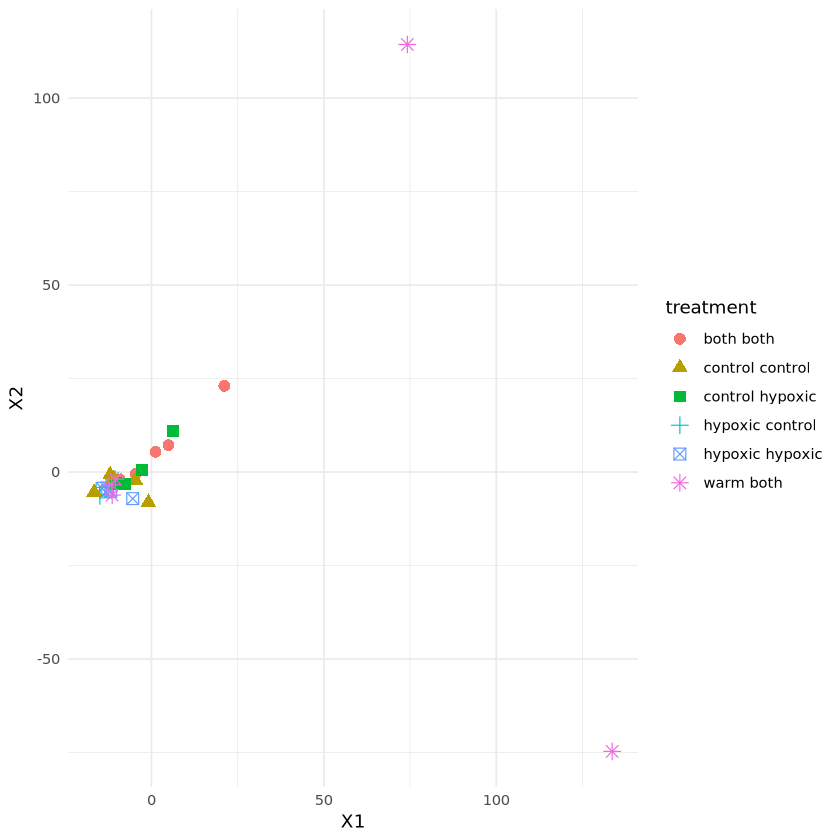

In [51]:
# plot
ggplot(mds, aes(X1, X2, shape = treatment, col = treatment)) + 
  geom_point(size = 3) +
  theme_minimal()

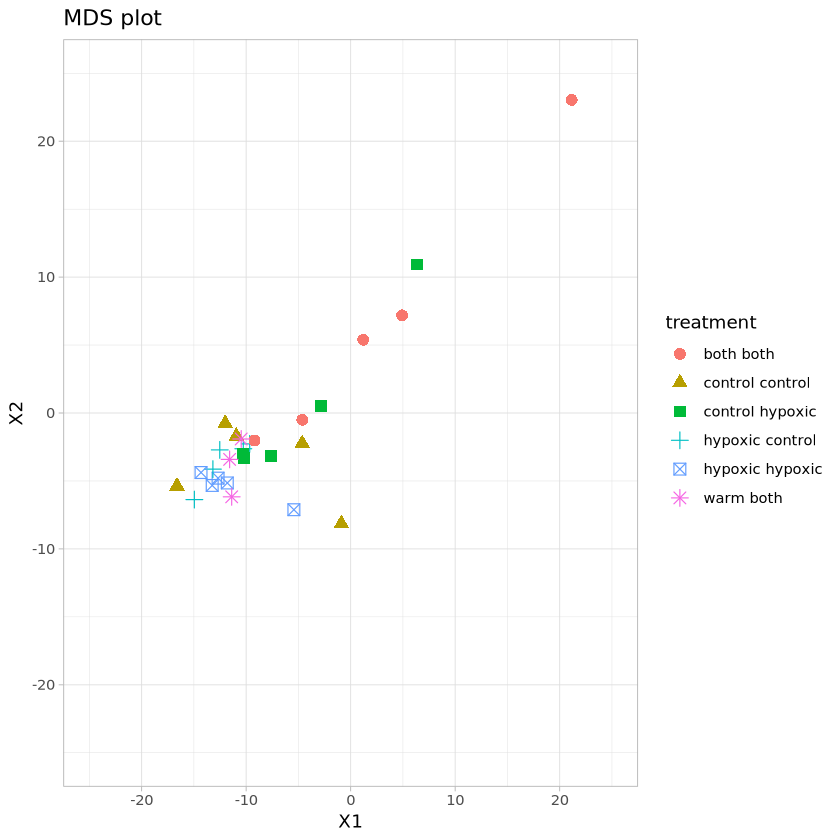

In [59]:
# plot
ggplot(mds, aes(X1, X2, shape = treatment, col = treatment)) + 
  geom_point(size = 3) +
coord_cartesian(xlim=c(-25,25), ylim = c(-25,25)) +
labs(title = "MDS plot") +
  theme_light()

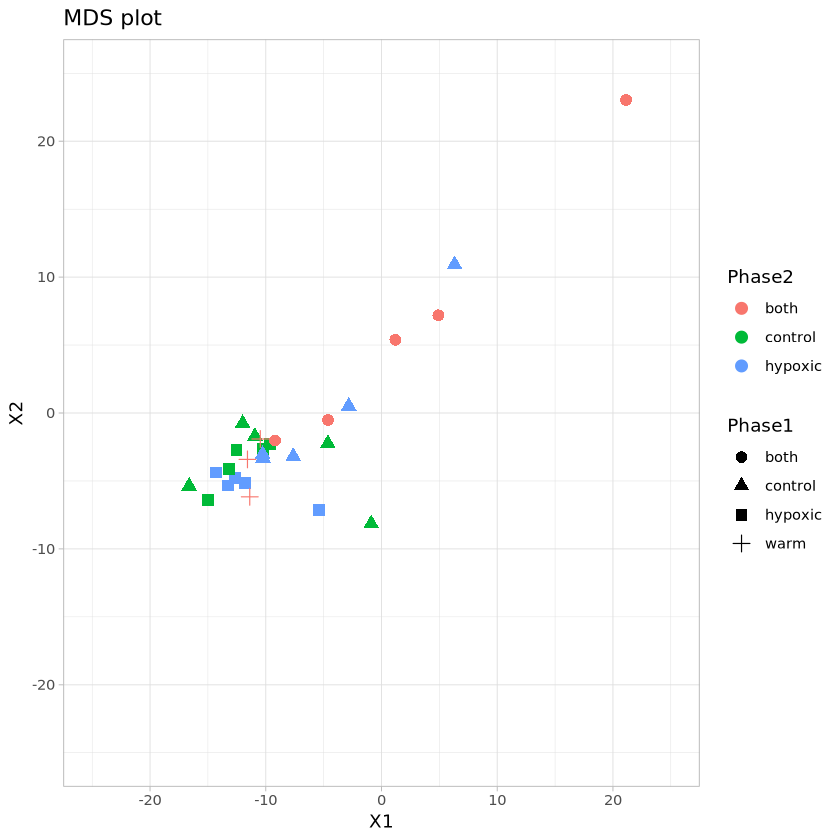

In [60]:
# plot
ggplot(mds, aes(X1, X2, shape = Phase1, col = Phase2)) + 
  geom_point(size = 3) +
coord_cartesian(xlim=c(-25,25), ylim = c(-25,25)) +
labs(title = "MDS plot") +
  theme_light()

above plot shows all samples - but for this analysis, I'm not using any of the warm both or oth. both samples - so want to remove those

In [63]:
# removing warm both and both both samples
meta_filtered <- filter(meta, meta$Phase2 != 'both')

# need to remove them from counts as well
counts_filtered <- counts2[, colnames(counts2) %in% rownames(meta_filtered)]

dim(meta_filtered)
dim(counts_filtered)

[1] 20  3

[1] 13544    20

In [64]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
dds <- DESeqDataSetFromMatrix(countData = counts_filtered,
                              colData = meta_filtered, 
                              design = ~ treatment)
dds=DESeq(dds)
resultsNames(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automa

[1] "Intercept"                                   
[2] "treatment_control.hypoxic_vs_control.control"
[3] "treatment_hypoxic.control_vs_control.control"
[4] "treatment_hypoxic.hypoxic_vs_control.control"

so we see that DESeq2 has recognized and assigned control control as the control condition - everything will be compared to this

In [65]:
# MDS plot

# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42,WBB-WBV-W69,WBG-BBB-W56,WBG-WBG-W44,WBO-BBR-W03,WBO-WBV-W64,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30
BBB-WBO-B21,0.00000,18.84577,20.92953,20.96794,18.21364,18.11468,20.63180,19.75147,20.22578,18.92113,19.59980,22.22072,22.99473,25.76891,19.89501,22.74966,21.92330,24.57036,22.87723,22.23458
BBB-WBV-B70,18.84577,0.00000,19.18891,20.44833,18.37856,18.70862,18.49159,19.88195,19.52910,22.14748,19.82340,21.78769,23.04090,27.07967,19.68026,20.36870,21.60692,24.96069,22.56522,21.60935
BBO-BBO-B16,20.92953,19.18891,0.00000,18.48364,18.67343,20.61852,17.09182,17.92361,16.80276,22.11230,19.36438,18.71328,20.35510,27.10422,18.51823,19.93818,19.39514,22.60180,18.58325,18.38694
BBO-BBY-B27,20.96794,20.44833,18.48364,0.00000,20.06915,19.96350,18.48062,18.78633,16.63747,23.02284,19.67587,19.59168,21.10106,26.91646,19.63858,21.92601,21.00382,23.25080,18.86815,17.57746
BBO-WBO-B16,18.21364,18.37856,18.67343,20.06915,0.00000,18.29444,19.18185,19.88428,18.89404,20.74670,18.86631,21.12054,22.26473,26.68688,18.52538,21.98739,20.68327,23.12099,20.82959,20.82289
BBO-WBV-B64,18.11468,18.70862,20.61852,19.96350,18.29444,0.00000,20.41040,20.58917,18.89354,21.39994,17.71932,21.61194,22.00616,25.44915,19.60662,22.17830,22.25292,24.32149,22.19753,21.13937


,X1,X2,Phase1,Phase2,treatment,sizeFactor
,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>
BBB-WBO-B21,-5.843530,-7.9131927,hypoxic,control,hypoxic control,2.383679
BBB-WBV-B70,-2.252235,-5.9162123,hypoxic,control,hypoxic control,2.070380
BBO-BBO-B16,3.785809,0.6607293,hypoxic,hypoxic,hypoxic hypoxic,1.679982
BBO-BBY-B27,2.993232,2.0566212,hypoxic,hypoxic,hypoxic hypoxic,1.131588
BBO-WBO-B16,-1.893454,-5.7008254,hypoxic,control,hypoxic control,2.459313
BBO-WBV-B64,-5.037877,-4.4132410,hypoxic,control,hypoxic control,2.191596


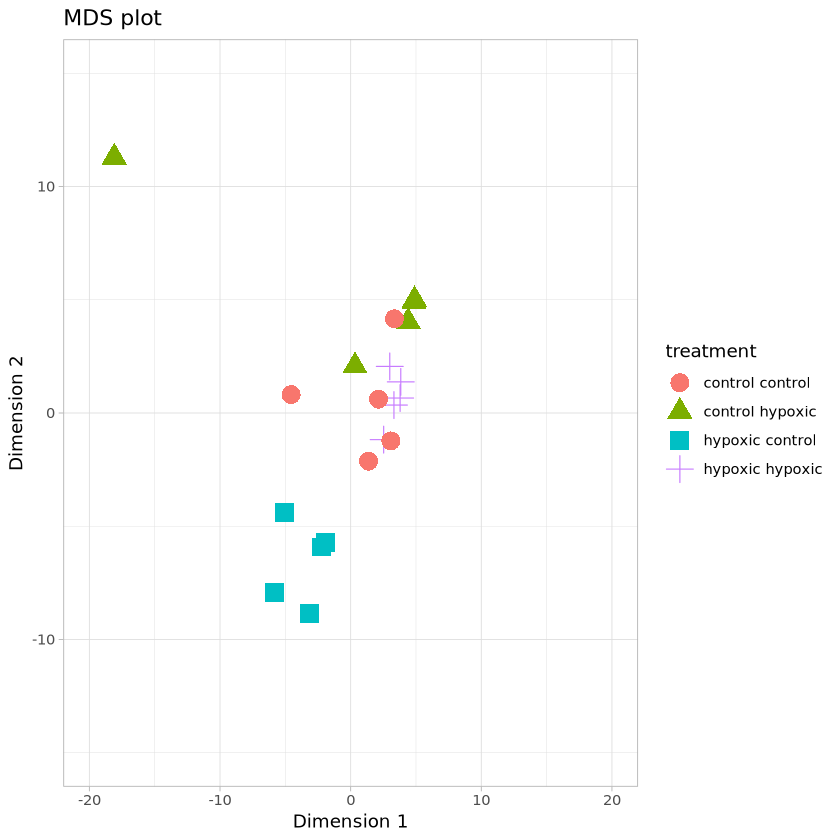

In [89]:
# plot
ggplot(mds, aes(X1, X2, shape = treatment, col = treatment)) + 
  geom_point(size = 5) +
coord_cartesian(xlim=c(-20,20), ylim = c(-15,15)) +
labs(title = "MDS plot", x = "Dimension 1", y = "Dimension 2") +
  theme_light()

above plot - how similar counts are for each treatment, compared to control control oysters. Color *and* shape denote the treatment

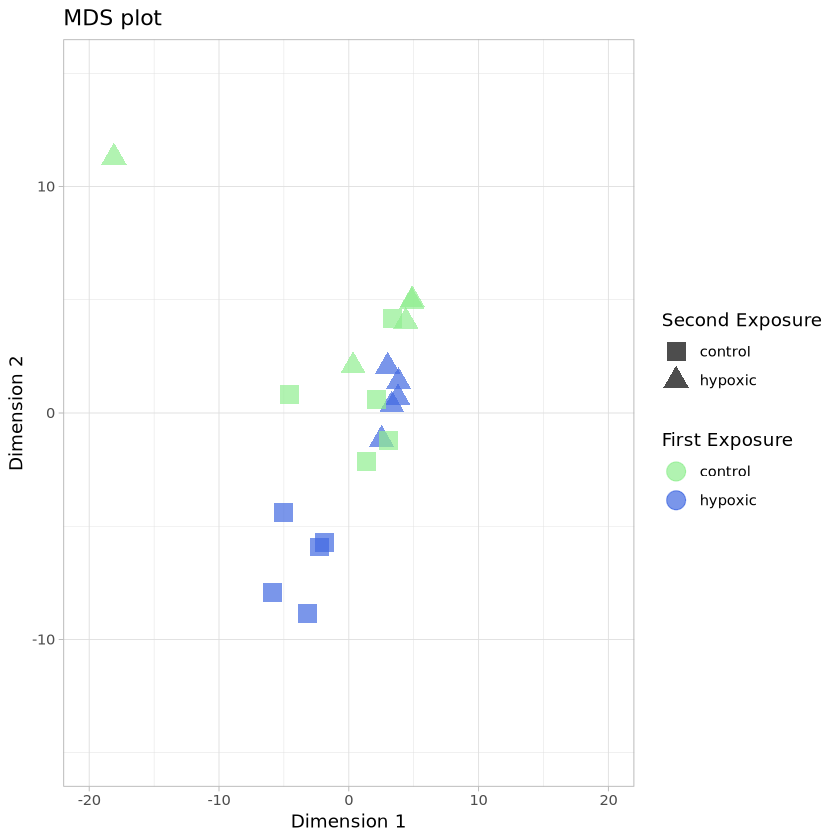

In [103]:
# plot
ggplot(mds, aes(X1, X2, shape = Phase2, col = Phase1)) + 
  geom_point(size = 5, alpha = 0.7) +
scale_shape_manual(values = c(15, 17)) +
coord_cartesian(xlim=c(-20,20), ylim = c(-15,15)) +
scale_color_manual(values = c('lightgreen','royalblue')) +
labs(title = "MDS plot", x = "Dimension 1", y = "Dimension 2", color = "First Exposure", shape = "Second Exposure") +
  theme_light()

same plot as above, but now the color denotes the first exposure (phase 1) and shape denotes second exposure (phase 2)

observations:
- hypoxia control oysters are clustering away from the group in the middle
- hypoxia hypoxia fall in the clump of all first exposure control oysters

*reminder that this is the differences/similarities of counts when compared to control control*